jupyter nbconvert prova.ipynb --to pdf --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags="['remove_cell']"

# Introduction

In this homework we will analyze data coming from a gene expression dataset of 79 patients with leukemia belonging to two subgroups: patients with a chromosomal translocation ("1") and patients cytogenetically normal ("-1"). The `gene_expr.tsv` file contains expression for 2,000 genes and additional columns with patient labels and the outcome variable (`y`). The aim is to perform a supervised analysis for prediction of the subgroups using support vector machines.

In [1]:
# support libraries
import numpy as np
from matplotlib import pyplot as plt  # import subplots, cm
import sklearn.model_selection as skm
import pandas as pd
from ISLP import load_data, confusion_table

# lab-specific libraries
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from ISLP.svm import plot as plot_svm

# Methods

To classify leukemia subgroups based on gene expression, the following machine learning techniques and evaluation strategies were employed:

• **Cross-validation (CV)**: K-fold cross-validation was used to obtain robust performance estimates and prevent overfitting. This technique systematically partitions the data into training and validation sets. It was combined with grid search to optimize key hyperparameters for each SVM model type (regularization parameter *C*, *gamma* for RBF, and *degree* for polynomial)    

• **Linear support vector machine (SVM)**: This algorithm seeks the optimal **linear boundary** (hyperplane) in the high-dimensional feature space to separate the two patient classes. It aims to maximize the margin between the hyperplane and the nearest data points (support vectors) of each class.    

• **Radial basis function (RBF) SVM**: A **non-linear** SVM utilizing the RBF kernel. It implicitly maps data into a higher-dimensional space, enabling the creation of complex, curved decision boundaries. Suitable for datasets where classes are not linearly separable in the original space.   

• **Polynomial SVM**: This **non-linear** SVM employs a polynomial kernel function. It maps the input data into a higher-dimensional feature space, allowing it to find polynomial decision boundaries between classes. The degree of the polynomial controls the flexibility of the boundary.

• **Principal component analysis (PCA)**: An unsupervised dimensionality reduction technique used to transform the high-dimensional gene expression data. It identifies principal components (linear combinations of original genes) that capture the maximum variance, facilitating visualization and potentially simplifying classification tasks.

# Data exploration and pre-processing

As expected, the dataset consists of 79 rows, each representing a patient, and 2002 columns, including expression measurements for 2000 genes along with two additional columns for patient labels and the outcome variable. The structure of the dataset remains unmodified, as there are no missing values that require imputation or removal.



In [2]:
dataf = pd.read_csv('gene_expr.tsv', sep='\t') #read tsv file
dataf.shape #check data set dimension

(79, 2002)

In [3]:
dataf.isnull().values.any() #check for any missing value

False

Given the nature of gene expression data, it is not unusual to observe a high dimensionality, with the number of features far exceeding the number of observations. While this characteristic can facilitate the identification of hyperplanes that effectively separate classes, it poses significant challenges for data visualization. Visualizing high-dimensional data typically necessitates dimensionality reduction techniques such as **Principal Component Analysis (PCA)**. However, by choosing not to apply these techniques, we will likely not be able to visually explore the data distribution and the hyperplanes derived from subsequent analyses.

# Linear support vector machine
To predict the presence or absence of the specific chromosomal feature via supervised learning, we employ SVMs. A **key consideration** is the dataset's high dimensionality (79 samples, 2000 genes). In such high-dimensional spaces, data points are often more easily separated by a linear boundary. Consequently, a linear SVM kernel is hypothesized to be effective, potentially avoiding the need for more complex RBF or polynomial kernels. This section focuses on implementing and evaluating the linear SVM. Later sections will compare its performance against the non-linear alternatives.  

As a first step, we partition the data into the feature matrix X (gene expressions) and the target vector y, which comprised 42 samples labeled *-1* and 37 samples labeled *1*, denoting the balance of the data set with respect to the outcome variable.

In [4]:
y = dataf['y'] #select only the column of outcome variable
X = dataf.drop(columns=['y', 'sampleID'], axis=1) #drop the additional columns of outcome variable and patient labels
X.shape

(79, 2000)

In [5]:
y.value_counts()

y
-1    42
 1    37
Name: count, dtype: int64

Subsequently, the dataset *(both features X and target y)* was manually divided into training and testing sets using an approximate 50/50 split, this splitting process is required to build the confusion matrix and the ROC curve. This resulted in a training set *(X_train, y_train)* containing 39 observations, comprising 21 samples labeled *-1* and 18 samples labeled *1*. The remaining 40 observations were allocated to the test set.

In [6]:
#manual split of test set and training set using skm
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.5, random_state=0)
X_train.shape

(39, 2000)

In [7]:
y_train.value_counts()

y
 1    21
-1    18
Name: count, dtype: int64

We proceed by fitting the linear SVM model *(kernel='linear')*. For this initial fit, the regularization parameter C is set to a placeholder, as its optimal value will be determined later through a dedicated hyperparameter tuning process (cross-validation).

In [8]:
svm_linear = SVC(C=10, kernel="linear") 

We applied 10-fold cross-validation to tune the regularization parameter 𝐶 of the linear SVM.\
In the `scikit-learn` library, cross-validation is managed using splitter generators from the `model_selection` submodule, such as the `KFold(n_splits)` class, which implements K-Fold cross-validation.\
To perform an exhaustive search over parameter values, we used the `GridSearchCV(model, param_grid, cv, ...)` function, which integrates cross-validation into the grid search process.\
By testing a pre-selected range of values, we were able to access the cross-validation metrics for each of the models stored in the attribute `grid.cv_results_`.

In [9]:
C_values = [1e-4, 1e-3, 0.01, 0.1, 1, 10, 100, 1e3, 1e4]
#create a ten folds cross validation object
kfold = skm.KFold(10, random_state=0, shuffle=True)
#create the gridsearch
grid = skm.GridSearchCV(svm_linear,
                        {"C": C_values},
                        cv=kfold,
                        scoring="accuracy") #scoring = how to measure the performance to pick the best one
grid.fit(X,y)
#access the cross-validation results (here the output will be truncated)
grid.cv_results_

{'mean_fit_time': array([0.02060578, 0.01950223, 0.02177954, 0.02372053, 0.02229166,
        0.01830826, 0.02077641, 0.02009282, 0.02246485]),
 'std_fit_time': array([0.00457592, 0.00376761, 0.00376833, 0.00385168, 0.00512067,
        0.00226909, 0.00470087, 0.00425669, 0.0051933 ]),
 'mean_score_time': array([0.01439521, 0.0138526 , 0.01677954, 0.01751201, 0.01465144,
        0.01640601, 0.01513033, 0.0127281 , 0.01432667]),
 'std_score_time': array([0.00411534, 0.00395134, 0.00364852, 0.00394364, 0.00454874,
        0.00597601, 0.00579666, 0.00320969, 0.00481997]),
 'param_C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0,
                    10000.0],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value=1e+20),
 'params': [{'C': 0.0001},
  {'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 1000.0},
  {'C': 10000.0}],
 'split0_test_score': array([0.125,

The performance of each model is quantified in terms of accuracy that one could extract by using `grid.cv_results_["mean_test_score"]`.\
As shown above, by looking at the attribute `mean_test_score` we can see how `C=0.1` results in the highest cross-validation accuracy of 0.8625. However, the accuracy is the same for every pre-selected value of `C` greater or equal than 0.1.\ We proceeded by extracting programmatically the best model, corresponding to the optimal `C` value, stored in the attribute `best_estimator_`. 

In [10]:
#access the optimal linear model
best_linear_mod = grid.best_estimator_
#fit the optimal linear model on training data
best_linear_mod.fit(X_train,y_train)

SVC(C=0.1, kernel='linear')

The cross-validation identified **C = 0.1** as the optimal choice for maximizing model performance on unseen data within the training set.\
In the last part of this section, the best linear SVM is fitted on the training data set resulting from the previous manual split. We will show the confusion matrix and the accuracy value of this model coming from our 50/50 split.

In [11]:
#prediction on test data
ypred_linear = best_linear_mod.predict(X_test)
#confusion matrix
confusion_table(ypred_linear, y_test)

Truth,-1,1
Predicted,,
-1,17,1
1,7,15


In [12]:
#accuracy
(ypred_linear == y_test).mean()

0.8

The accuracy obtained on the manually separated test set is 0.80, which is very close to the average accuracy of 0.86 from cross-validation, confirming the model’s good generalization performance.

Since we are working with high-dimensional gene expression data, at this stage of the analysis we considered applying dimensionality reduction techniques, specifically Principal Component Analysis (PCA), for visualization purposes only. Our goal was to reduce the dataset to two components in order to plot the data points along with the hyperplane obtained from the previous analysis.\
We then decided to fit a linear SVC on the PCA-transformed dataset to observe how the accuracy would be affected.

In [ ]:
pca = PCA(n_components=2) #initialize PCA
X_pca = pca.fit_transform(X) #fit PCA on the original dataset
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

X_train_pca = pd.DataFrame(X_train_pca) #convert transformed data into a dataframe
y_train= pd.Series(y_train).reset_index(drop=True) #reset the index of the training labels to align with the transformed training data

In [ ]:
C_values = [1e-4, 1e-3, 0.01, 0.1, 1, 10, 100, 1e3, 1e4]
#create a ten folds cross validation object
kfold = skm.KFold(10, random_state=0, shuffle=True)
#create the gridsearch
grid = skm.GridSearchCV(svm_linear,
                        {"C": C_values},
                        cv=kfold,
                        scoring="accuracy") #scoring = how to measure the performance to pick the best one
grid.fit(X_pca,y)
#access the best parameter combination
print("Optimal linear model: ", grid.best_estimator_)
print("Cross-validation accuracy of optimal model: ", grid.best_score_)

Optimal linear model:  SVC(C=10000.0, kernel='linear')
Accuracy of optimal model:  0.5571428571428572


After fitting a linear SVC on the transformed data, the cross validation accuracy dropped to 0.59, likely due to the loss of discriminative information during dimensionality reduction. Since PCA is unsupervised and only retains the directions of maximum variance, it may not preserve the features most relevant for classification.\
Notably, the optimal linear SVC returned a very high regularization parameter (C = 10,000). Such a large value indicates that the model heavily penalizes misclassifications on the training data, likely resulting in a very narrow margin. This behavior suggests a tendency to overfit, which may explain the relatively low accuracy.\
We decided to plot the resulting optimal SVC, but we will not proceed forward with the data transformation. The plot was generated using the ISLP function `plot_svm()` with the SVC fit and the transformed data. Crosses (`+`) indicate the support vectors and the remaining observations are plotted as circles, with misclassifications being highlighted.

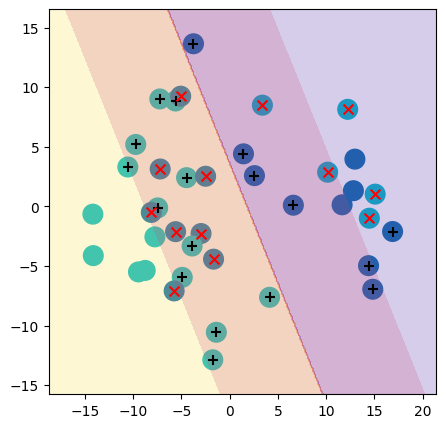

In [17]:
best_linear_mod_pca = grid.best_estimator_
best_linear_mod_pca.fit(X_train_pca,y_train)

fig, ax = plt.subplots(figsize=(5, 5))
plot_svm(X_train_pca, y_train, best_linear_mod_pca, ax=ax)

# Radial basis function and polynomial SVM

As previously mentioned, due to the nature of the dataset, a linear SVC is likely the most appropriate model for our classification problem.\
To support this assumption, in this section we fit two additional Support Vector Machines, one using an RBF kernel and the other using a polynomial kernel, and compare their performance to that of the linear SVC.\
Starting with our radial kernel, we employed the `SVC` function with the parameter `kernel="rbf"`. The two hyperparameters `C` and `gamma` were initially set to placeholder values. Then hyperparametry tuning by cross-validation was performed.

In [ ]:
svm_rbf = SVC(kernel="rbf", C=1, gamma=1)

In [ ]:
C_range = [1e-4, 1e-3, 0.01, 0.1, 1, 10, 100, 1e3, 1e4]
gamma_range = [0.5, 1, 2, 3, 4]

params = {"C": C_range, "gamma":gamma_range}

kfold = skm.KFold(10, random_state=0, shuffle=True)

grid = skm.GridSearchCV(svm_rbf, param_grid=params, cv=kfold, scoring="accuracy")
grid.fit(X_train, y_train)
print("Optimal rbf model: ", grid.best_estimator_)
print("Cross-validation accuracy of optimal model: ", grid.best_score_)

Optimal rbf model:  SVC(C=0.0001, gamma=0.5)
Cross-validation accuracy of optimal model:  0.5416666666666667


In [ ]:
best_rbf_svm = grid.best_estimator_
#fit the optimal linear model on training data
best_rbf_svm.fit(X_train,y_train)

SVC(C=0.0001, gamma=0.5)

In [ ]:
ypred_rbf = best_rbf_svm.predict(X_test)
confusion_table(ypred_rbf, y_test)

Truth,-1,1
Predicted,,
-1,0,0
1,24,16


In [ ]:
(ypred_rbf == y_test).mean()

0.4

After fitting an SVM with an RBF kernel, the accuracy dropped to 0.54. Interestingly, the model consistently predicted only class 1. This behavior suggests either an imbalance in the dataset or suboptimal hyperparameter settings.\
Since the data set was proven to be balanced, this outcome is likely due to underfitting caused by using the smallest values of C and gamma in the parameter grid. These conservative settings may have led the model to learn an overly smooth and simplistic decision boundary, failing to capture meaningful class distinctions.

To fit a polynomial SVM we employed the `SVC` function with the parameter `kernel="poly"`. The two hyperparameters `C` and `degree` were initially set to placeholder values. Then hyperparametry tuning by cross-validation was performed.

In [ ]:
svm_poly = SVC(kernel="poly", C=1, degree=2)

In [ ]:
C_range = [0.1, 1, 10, 100, 1000]
degree_range = [1, 2, 3, 4]

params = {"C": C_range, "degree":degree_range}

kfold = skm.KFold(10, random_state=0, shuffle=True)

grid = skm.GridSearchCV(svm_poly, param_grid=params, cv=kfold, scoring="accuracy")
grid.fit(X_train, y_train)
grid.cv_results_
print("Optimal polynomial model: ", grid.best_estimator_)
print("Cross-validation accuracy of optimal model: ", grid.best_score_)


Optimal polynomial model:  SVC(C=0.1, degree=4, kernel='poly')
Cross-validation accuracy of optimal model:  0.7


In [ ]:
best_poly_svm = grid.best_estimator_
#fit the optimal linear model on training data
best_poly_svm.fit(X_train,y_train)

SVC(C=0.1, degree=4, kernel='poly')

In [ ]:
ypred_poly = best_poly_svm.predict(X_test)
confusion_table(ypred_poly, y_test)

Truth,-1,1
Predicted,,
-1,16,1
1,8,15


In [ ]:
(ypred_poly == y_test).mean()

0.775

Given the high dimensionality of gene expression data, a linear decision boundary is generally expected to perform best, as complex kernels may introduce unnecessary variance. Nonetheless, the polynomial SVM achieved a cross-validation accuracy of 0.7, which, although lower than the 0.86 obtained with the linear kernel, is still relatively high. This suggests that the polynomial kernel was able to capture some underlying structure in the data, though it did not provide a significant advantage over the simpler linear model. These results reinforce the suitability of the linear kernel for this classification problem.

#  Gene selection

In gene expression analysis, it is common practice to filter out genes with low variability, as they often contribute little to the discrimination between classes and may introduce noise into the model. To enhance signal-to-noise ratio and focus on the most informative features, we selected only the top 5% most variable genes based on their standard deviation across samples. This filtering step significantly reduces the dimensionality of the data while retaining the genes most likely to carry meaningful biological or predictive information. We then repeated the analyses from the previous section using this reduced dataset to evaluate the impact of variability-based gene selection on model performance.

In [ ]:
gene_std = X.std(axis=0) #calculate the standard deviation of each gene (column-wise)
threshold = np.percentile(gene_std, 95) #compute the threshold corresponding to the 95th percentile of gene variability
top_genes = gene_std[gene_std >= threshold].index #select the genes whose standard deviation is greater than or equal to the threshold
X_filtered = X[top_genes] #filter the original dataset to keep only the most variable genes (top 5%)
X_filtered.shape

(79, 100)

We proceeded exactly as before: first, we performed a manual split of the dataset into training and test sets. Then, we initialized the SVM models with placeholder hyperparameter values before applying cross-validation to identify the optimal parameters for each kernel.

In [ ]:
#manual split of filtered training and test set using skm
X_train_f, X_test_f, y_train_f, y_test_f = skm.train_test_split(X_filtered, y, test_size=0.5, random_state=0)
y_train.value_counts()

y
 1    21
-1    18
Name: count, dtype: int64

## Linear SVM

In [ ]:
#DA TOGLIERE
svm_linear_filtered = SVC(C=10, kernel="linear")
#to train you have to call the method fit on the object
svm_linear_filtered.fit(X_train_f,y_train_f)
#Hyperparameter tuning
C_values = [0.001, 0.01, 0.1, 1, 5, 10, 100]
#create a five folds cross validation object (or splitter in sklearn)
kfold = skm.KFold(10, random_state=0, shuffle=True)
#create the gridsearch
grid = skm.GridSearchCV(svm_linear_filtered,
                        {"C": C_values},
                        cv=kfold,
                        scoring="accuracy") #scoring = how to measure the performance to pick the best one
grid.fit(X_filtered,y)
#access the best parameter combination
print("Optimal linear model: ", grid.best_estimator_)
print("Cross-validation accuracy of optimal model: ", grid.best_score_)

Optimal linear model:  SVC(C=0.01, kernel='linear')
Accuracy of optimal model:  0.8339285714285714


After filtering the dataset, we observe a slight decrease in classification accuracy (from 0.86 to 0.83). This suggests that while filtering helps reduce noise and dimensionality, it may also exclude some informative features.\
However, the optimal regularization parameter C decreased from 0.1 to 0.01, indicating that the reduced gene set led to a cleaner, more easily separable feature space.

In [ ]:
best_linear_mod_filtered = grid.best_estimator_
best_linear_mod_filtered.fit(X_train_f,y_train_f)
#prediction linear kernel
ypred_linear_filtered = best_linear_mod_filtered.predict(X_test_f)
ypred_linear_filtered
#confusion matrix
confusion_table(ypred_linear_filtered, y_test_f)

Truth,-1,1
Predicted,,
-1,17,0
1,7,16


In [ ]:
# accuracy
(ypred_linear_filtered == y_test_f).mean()

0.825

Interestingly, while cross-validation favored the full feature set, in a manual train-test split the filtered dataset achieved higher accuracy. This may reflect the linear SVM’s robustness in high-dimensional spaces when regularization is properly tuned, allowing it to leverage even weakly informative features spread across many genes.\
However, when training on fewer samples, as in a single split, the reduced feature space likely helped avoid overfitting and improved generalization, as the accuracy went from 0.8 to 0.825.\
This can be further highlighted by plotting the ROC curves produced by the linear SVC fitted on the original training set and by the one fitted on the filtered training set.

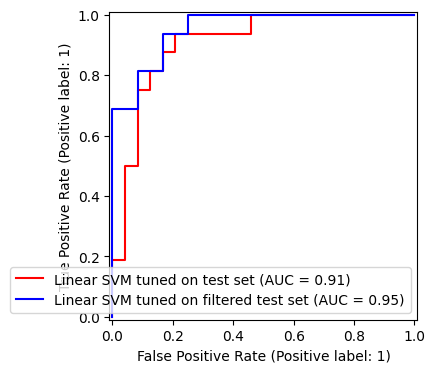

In [ ]:
roc_curve = RocCurveDisplay.from_estimator  # shorthand
fig, ax = plt.subplots(figsize=(4, 4))
roc_curve(best_linear_mod, X_test, y_test, name="Linear SVM tuned on test set", ax=ax, color="r")
roc_curve(best_linear_mod_filtered, X_test_f, y_test_f, name="Linear SVM tuned on filtered test set", ax=ax, color="b");

## RBF and polynomial SVM

An overall increase in performance can be also observed when using RBF annd polynomial kernels.

In [ ]:
#DA TOGLIERE
svm_rbf_filtered = SVC(C=100, gamma=0.5, kernel="rbf")
#to train you have to call the method fit on the object
svm_rbf_filtered.fit(X_train_f,y_train_f)
#Hyperparameter tuning
C_values = [0.001, 0.01, 0.1, 1, 5, 10, 100]
gamma_range = [0.5, 1, 2, 3, 4]
#create a five folds cross validation object (or splitter in sklearn)
kfold = skm.KFold(5, random_state=0, shuffle=True)
#create the gridsearch
grid = skm.GridSearchCV(svm_rbf_filtered,
                        {"C": C_values, "gamma": gamma_range},
                        cv=kfold,
                        scoring="accuracy") #scoring = how to measure the performance to pick the best one
grid.fit(X_filtered,y)
#access the best parameter combination
print("Optimal rbf model: ", grid.best_estimator_)
print("Cross-validation accuracy of optimal model: ", grid.best_score_)

Optimal rbf model:  SVC(C=0.001, gamma=0.5)
Accuracy of optimal model:  0.45583333333333337


In [ ]:
best_rbf_svm_filtered = grid.best_estimator_
best_rbf_svm_filtered.fit(X_train_f,y_train_f)
#prediction rbf kernel
ypred_rbf_filtered = best_rbf_svm_filtered.predict(X_test_f)
ypred_rbf_filtered
#confusion matrix
confusion_table(ypred_rbf_filtered, y_test_f)

Truth,-1,1
Predicted,,
-1,0,0
1,24,16


In [ ]:
# accuracy
(ypred_rbf_filtered == y_test_f).mean()

0.4

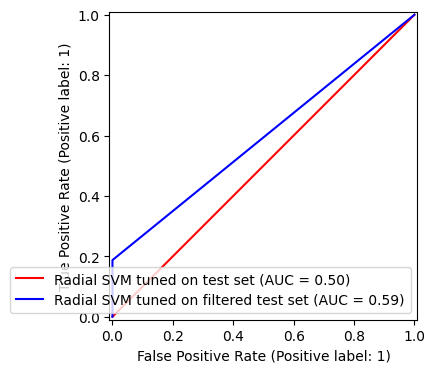

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
roc_curve(best_rbf_svm, X_test, y_test, name="Radial SVM tuned on test set", ax=ax, color="r")
roc_curve(best_rbf_svm_filtered, X_test_f, y_test_f, name="Radial SVM tuned on filtered test set", ax=ax, color="b");

In [ ]:
#DA TOGLIERE
svm_poly_filtered = SVC(C=100, degree=2, kernel="poly")
#to train you have to call the method fit on the object
svm_poly_filtered.fit(X_train_f,y_train_f)
#Hyperparameter tuning
C_values = [0.001, 0.01, 0.1, 1, 5, 10, 100]
degree_range = [1, 2, 3, 4]
#create a five folds cross validation object (or splitter in sklearn)
kfold = skm.KFold(5, random_state=0, shuffle=True)
#create the gridsearch
grid = skm.GridSearchCV(svm_poly_filtered,
                        {"C": C_values, "degree": degree_range},
                        cv=kfold,
                        scoring="accuracy") #scoring = how to measure the performance to pick the best one
grid.fit(X_filtered,y)
#access the best parameter combination
print("Optimal polynomial model: ", grid.best_estimator_)
print("Cross-validation accuracy of optimal model: ", grid.best_score_)

Optimal polynomial model:  SVC(C=0.1, degree=2, kernel='poly')
Accuracy of optimal model:  0.8208333333333334


In [ ]:
best_poly_svm_filtered = grid.best_estimator_
best_poly_svm_filtered.fit(X_train_f,y_train_f)
#prediction linear kernel
ypred_poly_filtered = best_poly_svm_filtered.predict(X_test_f)
ypred_poly_filtered
#confusion matrix
confusion_table(ypred_poly_filtered, y_test_f)

Truth,-1,1
Predicted,,
-1,17,0
1,7,16


In [ ]:
# accuracy
(ypred_poly_filtered == y_test_f).mean()

0.825

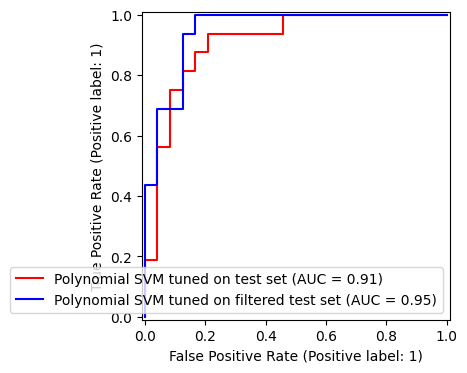

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
roc_curve(best_poly_svm, X_test, y_test, name="Polynomial SVM tuned on test set", ax=ax, color="r")
roc_curve(best_poly_svm_filtered, X_test_f, y_test_f, name="Polynomial SVM tuned on filtered test set", ax=ax, color="b");

Again, after this analysis, we can observe how the performance of the polynomial SVM is almost as high as that of the linear one, with the accuracy on the test set being identical.\
The identical AUC values for both the linear and polynomial SVCs on the original and filtered datasets suggest that both models rank positive and negative samples similarly, despite potential differences in classification boundaries.

# Conclusion

- Draw some conclusions from both the analyses that you have conducted.

(quando parli dell'accuratezza alta del poly :) )
Between two models with similar performance, simpler is usually better (Occam’s Razor). The linear SVM is not only more interpretable and faster, but also likely to generalize better — especially on small or noisy datasets, which is common in biological data.\
 This implies that the polynomial kernel does not significantly change the model’s discriminatory ability compared to the linear kernel in this specific problem. Overall, these results reinforce the idea that a linear decision boundary is sufficient for this classification task, and adding polynomial complexity does not substantially improve discrimination.

(quando parli del parametro c della linear svc che è passato dal 0.1 del non filtrato allo 0.01 del filtrato :) ) With fewer noisy or irrelevant genes, a more regularized model (smaller C) was sufficient to achieve good performance, reducing the risk of overfitting. In contrast, the full dataset required a slightly more flexible decision boundary, potentially to compensate for the higher dimensionality and presence of less informative features.